In [1]:
import numpy as np
import matplotlib.pylab as plt
from tqdm import trange

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn

---

### DATA

In [3]:
def fetch(url):
    import os, requests, gzip, hashlib, numpy
    filepath = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(filepath):
        with open(filepath, 'rb') as f:
            data = f.read()
    else:
        with open(filepath, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return numpy.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [4]:
x_train = fetch('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')[0x10:].reshape(-1, 28, 28) / 255.0

Min: 0.0 Max: 1.0


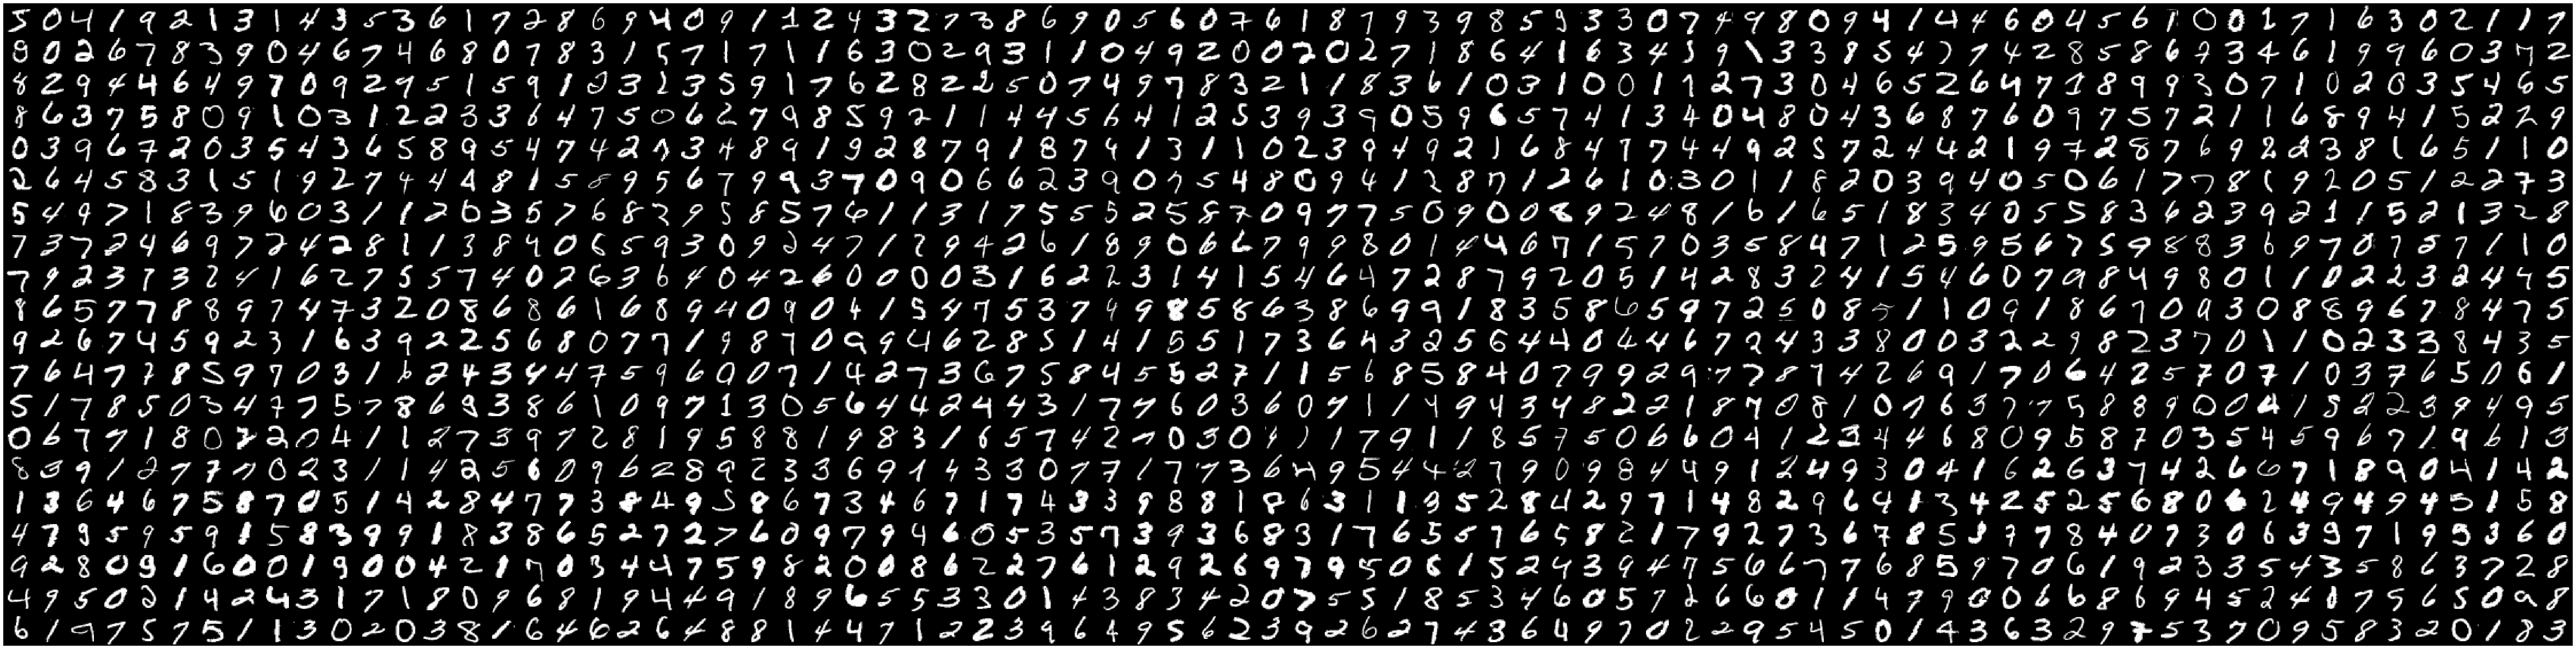

In [5]:
result = np.concatenate([np.concatenate(x_train[i*80:(i+1)*80], axis=1) for i in range(20)])

plt.figure(figsize=(80,20))
plt.imshow(result, 'gray')
plt.axis('off')
plt.tight_layout()

print('Min:', np.min(x_train), 'Max:', np.max(x_train))

---

### GENERATOR & DISCRIMINATOR

In [6]:
n_chan = 1
x_dim = 128
z_dim = 100 # Size of z latent space (Generator input)
g_hidden = 64 # Generator feature size
d_hidden = 64 # Discriminator feature size

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.x_in = nn.Sequential(
            nn.ConvTranspose2d(z_dim, g_hidden * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(g_hidden * 8),
            nn.ReLU(True)
        )
        self.l1 = nn.Sequential(
            nn.ConvTranspose2d(g_hidden * 8, g_hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_hidden * 4),
            nn.ReLU(True)
        )
        self.l2 = nn.Sequential(
            nn.ConvTranspose2d(g_hidden * 4, g_hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_hidden * 2),
            nn.ReLU(True)
        )
        self.l3 = nn.Sequential(
            nn.ConvTranspose2d(g_hidden * 2, g_hidden, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_hidden),
            nn.ReLU(True)
        )
        self.x_out = nn.Sequential(
            nn.ConvTranspose2d(g_hidden, n_chan, 1, 1, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.x_in(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.x_out(x)
        return x

In [9]:
netG = Generator()
netG.apply(weights_init)

g_params = netG.parameters()
print("Nparams:", sum(p.nelement() for p in g_params))
print(netG.eval())

Nparams: 3573696
Generator(
  (x_in): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (x_out): Sequential(
    (

In [10]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.x_in = nn.Sequential(
            nn.Conv2d(n_chan, d_hidden, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.l1 = nn.Sequential(
            nn.Conv2d(d_hidden, d_hidden * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_hidden * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.l2 = nn.Sequential(
            nn.Conv2d(d_hidden * 2, d_hidden * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_hidden * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.x_out = nn.Sequential(
            nn.Conv2d(d_hidden * 4, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.x_in(x)
        x = self.l1(x)
        x = self.l2(x)
        x = self.x_out(x)
        return x

In [11]:
netD = Discriminator()
netD.apply(weights_init)

d_params = netD.parameters()
print("Nparams:", sum(p.nelement() for p in g_params))
print(netD.eval())

Nparams: 0
Discriminator(
  (x_in): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (l1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (l2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (x_out): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Sigmoid()
  )
)


---

### TRAINING

In [12]:
bs = 64
lr = 2e-4
simlen = 1000

real_label = 1
fake_label = 0

In [13]:
loss_function = nn.BCELoss()

optimD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [14]:
d_loss, g_loss = [], []

for i in (t := trange(simlen)):
    idx = np.random.randint(0, x_train.shape[0], size=bs)
    data = torch.tensor(x_train[idx].reshape((-1,1,28,28))).float()
    label = torch.full((data.size(0),), real_label).float()

    for i in range(bs):
        # Discriminator - train with real
        netD.zero_grad
        d_real = netD(data)

        errD_real = loss_function(d_real.squeeze(), label)
        errD_real.backward()

        # Discriminator - train with fake
        noise = torch.randn(bs, z_dim, 1, 1)
        label.fill_(fake_label)
        g_fake = netG(noise)
        d_fake = netD(g_fake.detach())

        errD_fake = loss_function(d_fake.squeeze(), label)
        errD_fake.backward()
        optimD.step()

        errD = errD_real + errD_fake

        # Generator
        netG.zero_grad()
        label.fill_(real_label)
        d_fake = netD(g_fake.detach())
        
        errG = loss_function(d_fake.squeeze(), label)
        errG.backward()
        optimG.step()

    d_loss.append(errD.item())
    g_loss.append(errG.item())

    t.set_description("Discriminator loss %.2f Generator loss %.2f" % (errD.item(), errG.item()))

D Loss 0.50 G Loss 1.01: 100%|██████████| 5/5 [02:10<00:00, 26.07s/it]


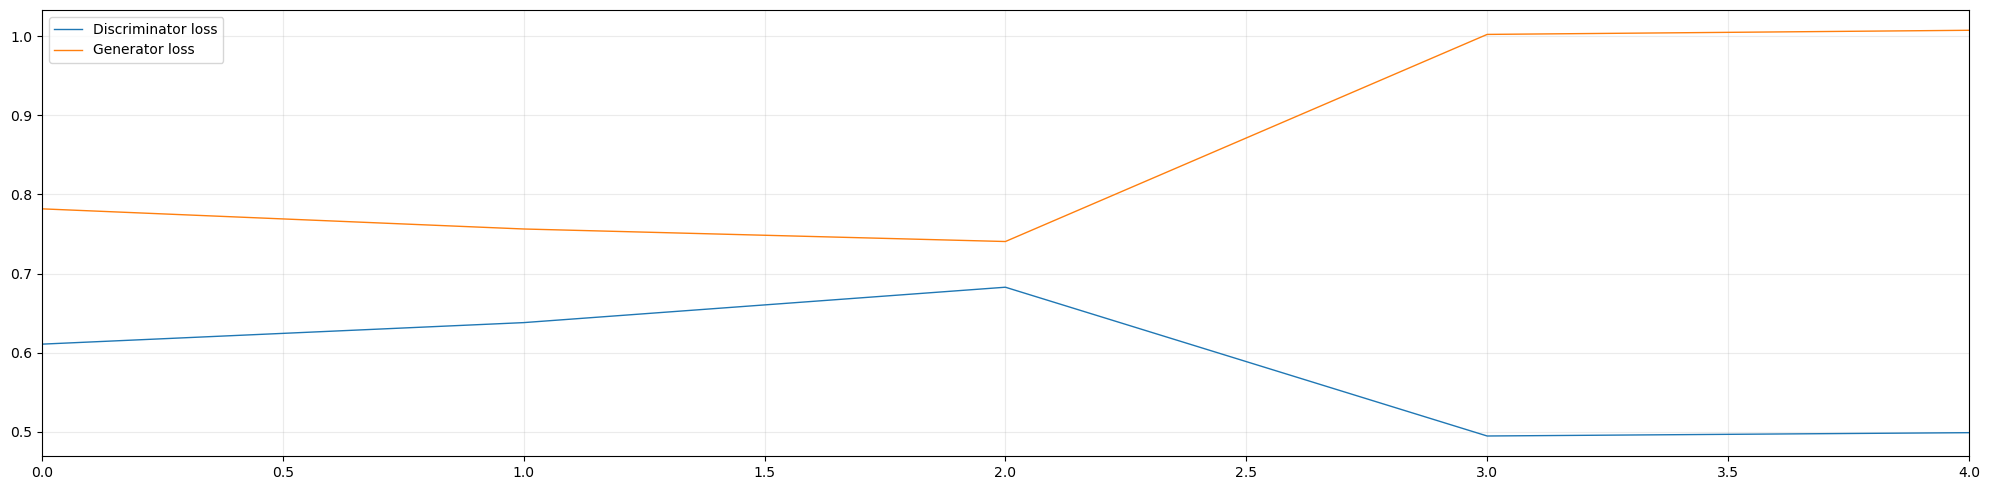

In [15]:
plt.figure(figsize=(20,5))
plt.plot(d_loss, lw=1, label='Discriminator loss'), plt.plot(g_loss, lw=1, label='Generator loss')
plt.xlim(0, len(d_loss)-1)
plt.grid(alpha=0.25), plt.legend()
plt.tight_layout()

---

### INFERENCE

In [16]:
test_noise = torch.randn(bs, z_dim, 1, 1)
test_result = netG(test_noise)

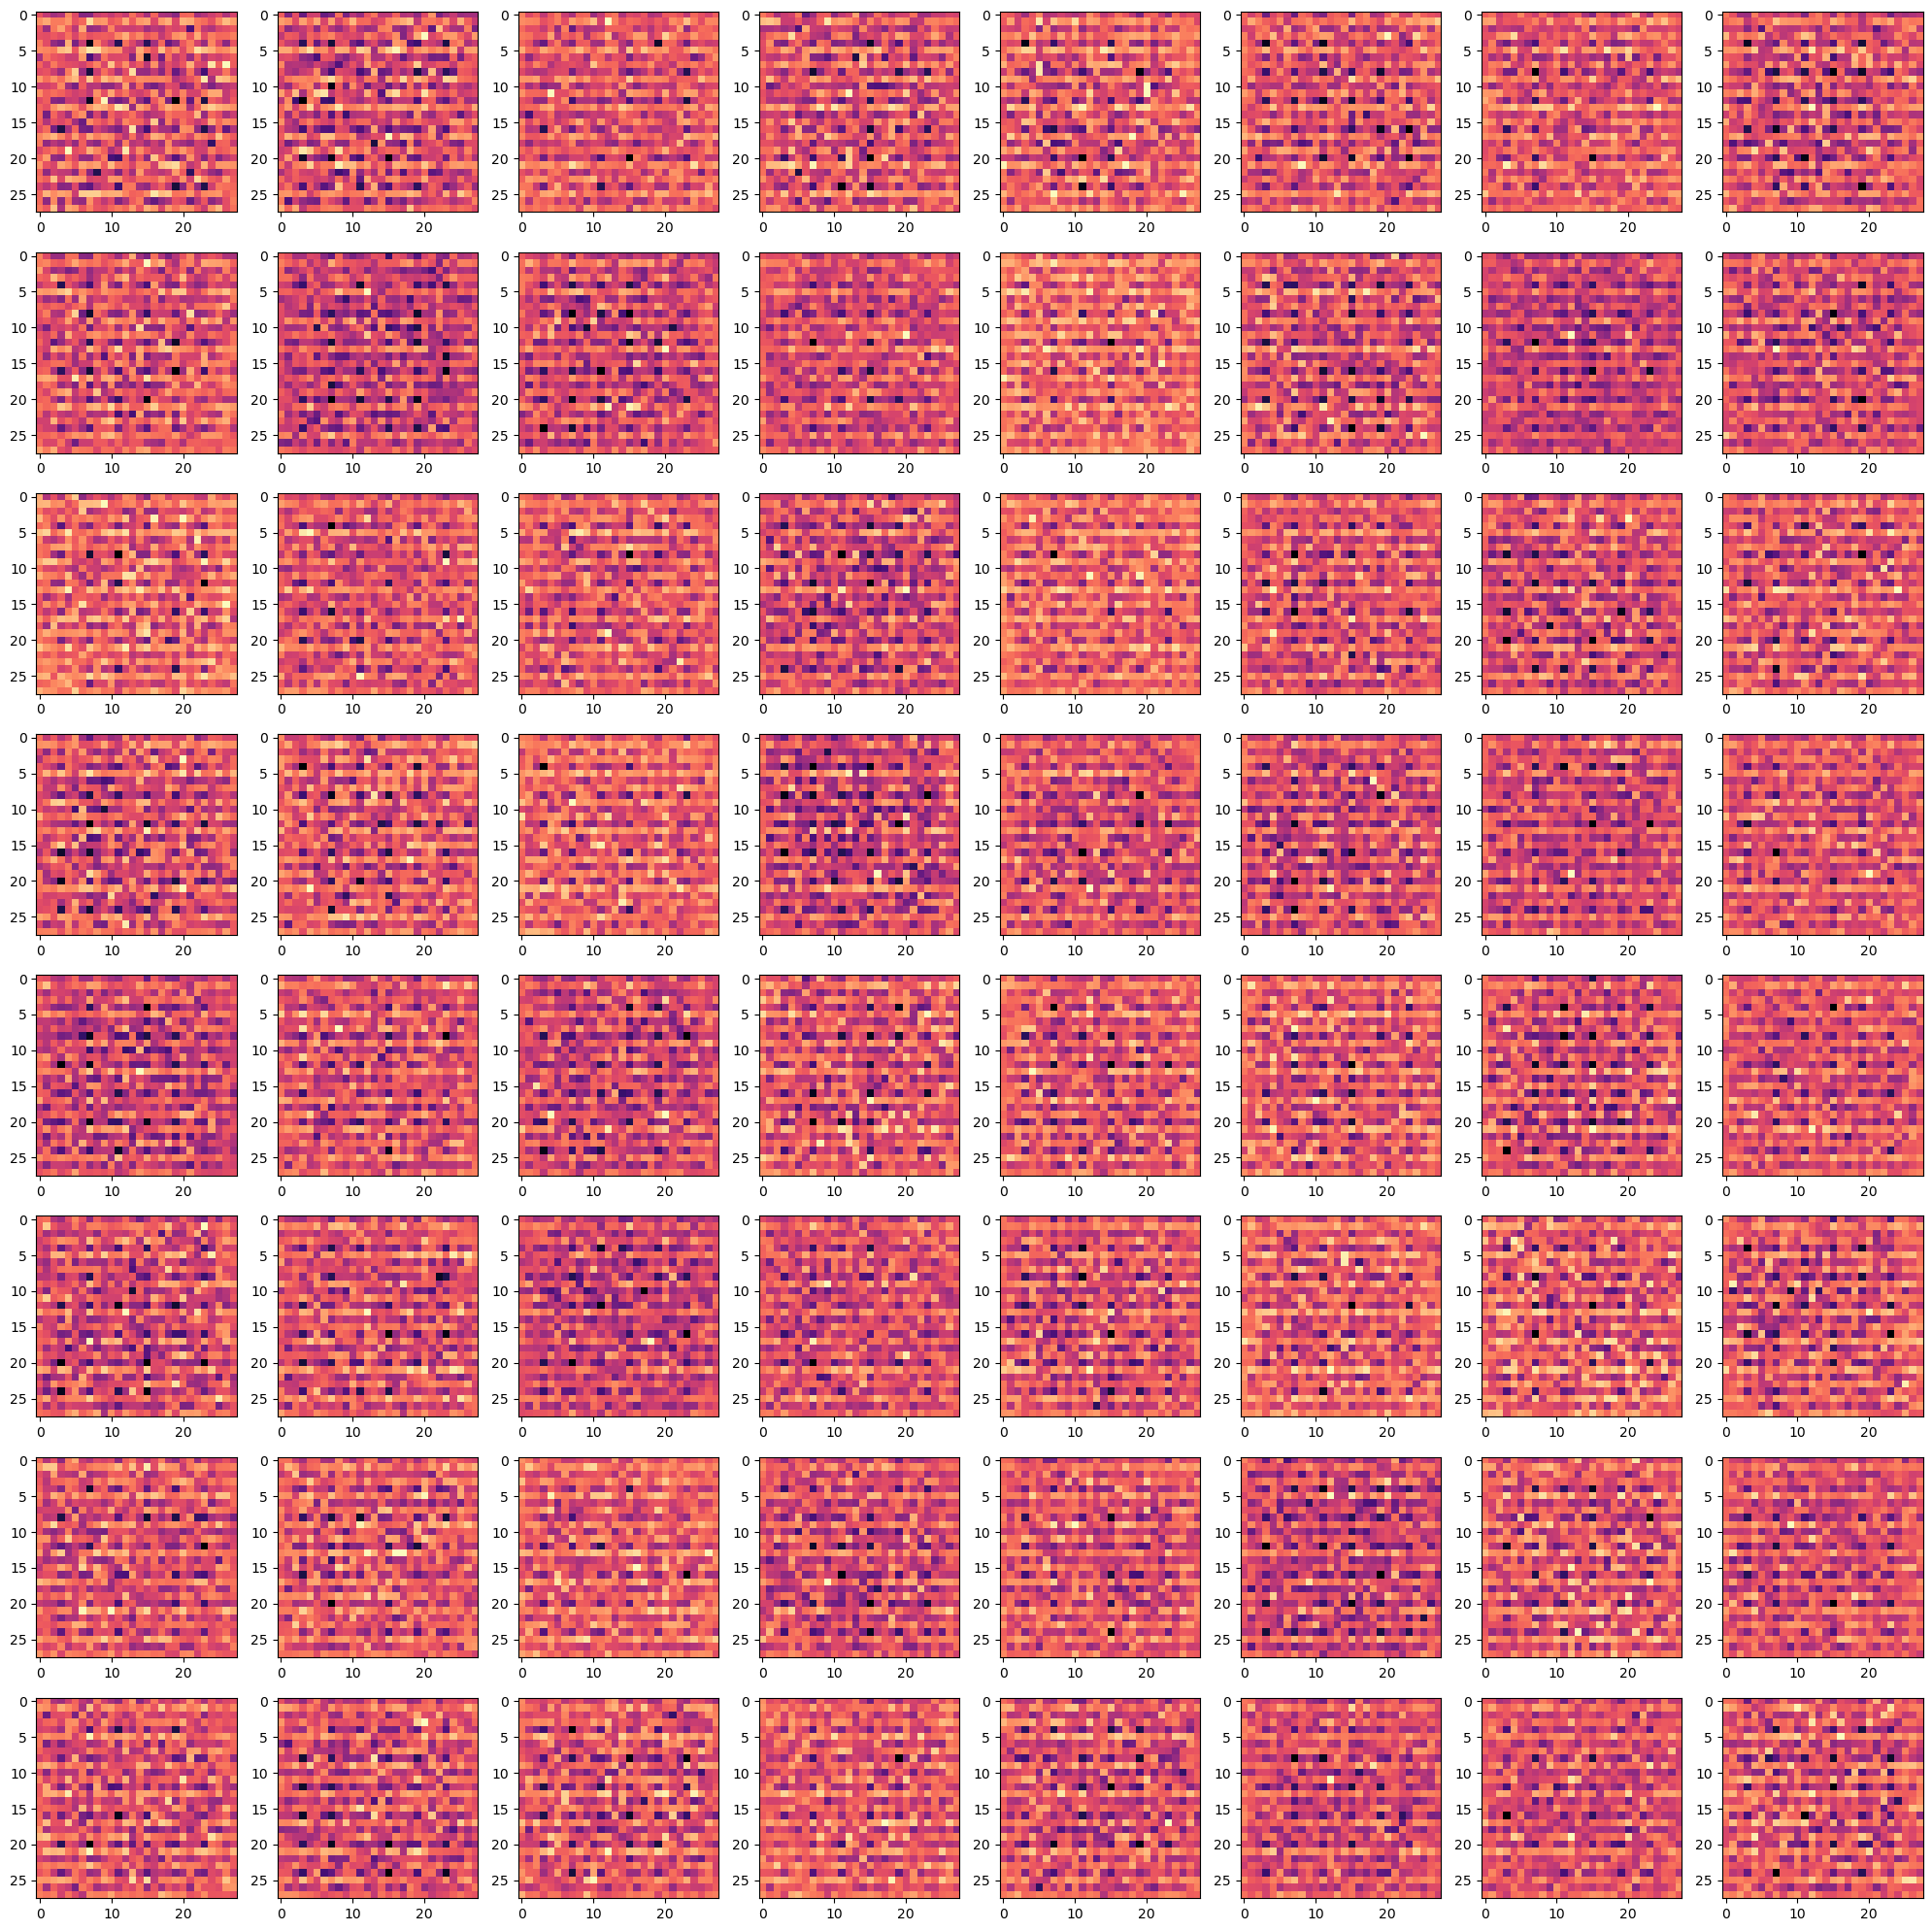

In [17]:
plt.figure(figsize=(20,20))
for i in range(bs):
    plt.subplot(8, 8, i+1)
    plt.imshow(test_result.detach()[i][0], 'magma')

plt.tight_layout()